# Mensurando a mobilidade intergeracional educacional no Brasil
<b>TODO:</b> 
<ul>
    <li>Criar cabeçalho</li>
    <li>Breve resumo</li>
</ul>


In [1]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sea
#from folium import plugins
import geopandas as gpd

warnings.filterwarnings("ignore")
%matplotlib inline

import statsmodels.formula.api as sm
from statsmodels.api import add_constant

## carrega dataframe inicial
df = pd.read_stata('base_de_dados_ExerciocioI (1).dta')
df.head()

,ano,co_municipio_residencia,co_uf_residencia,sg_uf_residencia,idade,n_pessoas_fam,feminino,preto,branco,publico,privada,nota_enem,educ_pai,educ_mae,renda_fam
0,2017,3105905,31,MG,50.0,5,1,0,0,NaN,NaN,542.419983,C,B,B
1,2017,4109708,41,PR,17.0,4,1,0,1,NaN,NaN,540.119995,F,D,E
2,2017,2609600,26,PE,17.0,5,1,1,0,NaN,NaN,501.140015,C,F,C
3,2017,2918407,29,BA,16.0,2,1,0,0,NaN,NaN,514.940002,E,E,B
4,2017,3170107,31,MG,17.0,5,1,0,0,NaN,1.0,511.299988,E,D,C


# Questão 1
[escrever pergunta aqui]

In [2]:
# as variáveis feminino, preto, branco, publico, privada só faz sentido falar da quantidade
variaveis = ['idade', 'n_pessoas_fam', 'nota_enem', 'feminino', 'preto', 'branco', 'publico','privada']

[escrever sobre as quantidades identificadas no dataset]

In [3]:
#quantidades
df[variaveis].describe()[:1]

,idade,n_pessoas_fam,nota_enem,feminino,preto,branco,publico,privada
count,99998.0,100000.0,100000.0,100000.0,100000.0,100000.0,133.0,2293.0


[escrever sobre máx, mín, média das variáveis idade, n_pessoas_fam]

In [4]:
df[variaveis[0:3]].describe()

,idade,n_pessoas_fam,nota_enem
count,99998.000000,100000.000000,100000.000000
mean,22.358877,3.972260,520.608032
std,7.261332,1.522772,79.858727
min,14.000000,1.000000,154.919998
25%,18.000000,3.000000,467.760010
50%,20.000000,4.000000,515.320007
75%,24.000000,5.000000,569.840027
max,77.000000,20.000000,818.140015


2. Apresente gráficos de densidade comparando o desempenho no ENEM dos seguintes grupos:

homens e mulheres
escolas publicas e privadas
pretos e brancos
pais educados e pais não educados.

In [5]:
## trecho para criar dataframe responsável por exibir histogramas

df_densidade = pd.DataFrame()
df_densidade['nota'] = df['nota_enem']


# homem / mulher
df_densidade['homem'] = (df[df['feminino'] == 0])['nota_enem']
df_densidade['mulher']= (df[df['feminino'] != 0])['nota_enem']


# publico / privada
df_densidade['publico']= (df[df['publico'] == 1])['nota_enem']
df_densidade['privada']= (df[df['privada'] == 1])['nota_enem']


# pretos / brancos
df_densidade['pretos']= (df[df['preto'] == 1])['nota_enem']
df_densidade['brancos']= (df[df['branco'] == 1])['nota_enem']


# pais educados / pais não educados.
# obs1. pais com ensino fundamental 2 completo serão considerados educados 
# obs2. se ao menos um dos dois forem educados os pais serão considerados educados.
v_educ = ['D','E','F','G'] ## >= Ensino Fundamental 2 
v_n_educ = ['A','B','C' ] ## < Ensino Fundamental 2

# se ao menos um dos dois pais forem educados (D,E,F e G), então o aluno é considerado com pais educados
df_densidade['pais_educ']= df.loc[df.educ_pai.isin(v_educ) | df.educ_mae.isin(v_educ)]['nota_enem']
df_densidade['pais_n_educ']= df.loc[df.educ_pai.isin(v_n_educ) & df.educ_mae.isin(v_n_educ)]['nota_enem']

[homens e mulheres]

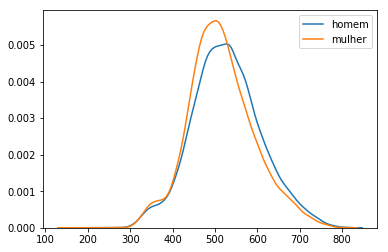

In [6]:
# valores NaN removidos
sea.kdeplot(df_densidade.homem.dropna());
sea.kdeplot(df_densidade.mulher.dropna());

[escolas publicas e privadas]

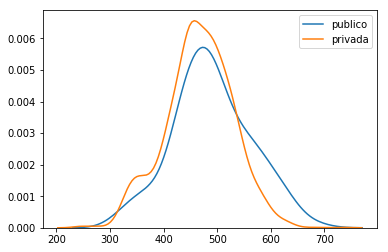

In [7]:
# dados da rede publica não são representativos [apenas 133 de 100k]

sea.kdeplot(df_densidade.publico.dropna());
sea.kdeplot(df_densidade.privada.dropna());

[pretos e brancos]

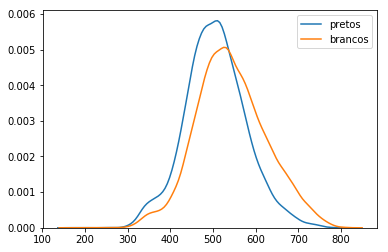

In [8]:
sea.kdeplot(df_densidade.pretos.dropna());
sea.kdeplot(df_densidade.brancos.dropna());

[pais educados e pais não educados]

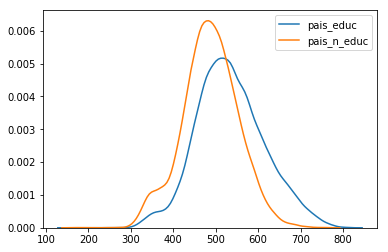

In [9]:
sea.kdeplot(df_densidade.pais_educ.dropna());
sea.kdeplot(df_densidade.pais_n_educ.dropna());

# 3. Monte uma tabela contendo as estimativas de β e α. Interpretem os resultados (magnitude e significância). Testem diferentes formas de medir o ranking educacional dos pais.

[rij =α+βRPi+eij]

In [10]:
# funções utilizadas para criar os clusters por estado

# coluna que será utilizada para delimitar o território (sg_uf_residencia ou co_municipio_residencia)
group_column = 'sg_uf_residencia'

# unidade de medida utilizada para criar os clustes (nota_enem)
grade_column = 'nota_enem'

# rankings da renda, educacao dos pais e das notas dos alunos
income_ranking = ['A','B','C','D','E','F','G','H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']
educ_ranking = ['A','B','C','D','E','F','G'] #,'H']   # H removido da análise

# ranking poderá ser alterado para testes
grade_ranking = ['A','B','C','D','E','F','G'] #,'H']  #


# função que define os limites da unidade de medida
# data: dataframe
# group_by: coluna utilizada para agrupar
#                Caso preenchido o ranking será contabulizado tomando apenas as notas
#                obtidas por alunos de um mesmo grupo (sg_uf_residencia ou co_municipio_residencia)
#                essa opção fará uma _normalização_ das notas por localidade
# clusters: domínio do ranking
#
# return: Retorna os limites de cada cluster para cada grupo (se informado)
def group_fixed_range(data, group_by, clusters):
    # colunas do range
    col = [group_by]
    for c in clusters:
        col.append(c)
        
    # caso não seja informado o grupo, o ranking será realizado 
    # utilizando todo o dataset
    group = pd.DataFrame()
    if len(group_by) == 0:
        fixed_range = ['']
        _max = max(data[grade_column])         # maior nota do grupo
        _min = min(data[grade_column])         # menor nota do grupo
        _offset = (_max - _min) / len(clusters)
        for c in range(1,len(clusters)+1):
            fixed_range.append(_min + _offset * c)
        group = group.append(pd.DataFrame([fixed_range], columns=col), ignore_index=True)
        return group
    
    # recupera os valores a serem a grupados
    keys = data[group_by].unique()
    group = pd.DataFrame(columns=col)

    # realiza o cáculo do range de cada cluster para cada grupo
    for key in keys:
        df_key = data[data[group_by] == key]     # linhas de um mesmo grupo (key)
        
        fixed_range = [key]
        _max = max(df_key[grade_column])         # maior nota do grupo
        _min = min(df_key[grade_column])         # menor nota do grupo
        _offset = (_max - _min) / len(clusters)  # intervalo de cada cluster
        
        for c in range(1, len(clusters) + 1):
            fixed_range.append(_min + _offset * c)
        group = group.append(pd.DataFrame([fixed_range], columns=col), ignore_index=True)
    return group


# Rankea uma amostra a partir dos parâmetros
# data: dataframe
# group: grupo contendo os limites de cada cluster
# group_by: coluna utilizada para agrupar
#                Caso preenchido o ranking será contabulizado tomando apenas as notas
#                obtidas por alunos de um mesmo grupo (sg_uf_residencia ou co_municipio_residencia)
#               essa opção fará uma _normalização_ das notas por localidade
# clusters: domínio do ranking
#
# return: Retorna o valor em texto do ranking
def ranking(row, group, group_by, clusters):
    # verifica se a condição de agrupamento foi informada
    if len(group_by) >0:    
        g = group[group[group_by] == row[group_by]]
    else:
        g = group

    # itera entre os clusters
    for c in clusters:
        if (row[grade_column] <= g[c].values):
            return c
    return 'NaN'


# Rankea uma amostra a partir dos parâmetros
# data: dataframe
# group: grupo contendo os limites de cada cluster
# group_by: coluna utilizada para agrupar
#                Caso preenchido o ranking será contabulizado tomando apenas as notas
#                obtidas por alunos de um mesmo grupo (sg_uf_residencia ou co_municipio_residencia)
#                essa opção fará uma _normalização_ das notas por localidade
# clusters: domínio do ranking
#
# return: Retorna o índice do ranking
def ranking_index(row, group, group_by, clusters):
    # verifica se a condição de agrupamento foi informada
    if len(group_by) >0:
        g = group[group[group_by] == row[group_by]]
    else:
        g = group
    
    # itera entre os clusters
    for c in range(len(clusters)):
        if (row[grade_column] <= g[clusters[c]].values):
            return c + 1
    return -1


# Adiciona colunas ao dataset
# data: dataframe
# group_by: coluna utilizada para agrupar
#
# return: dataframe com novas colunas
def add_columns(data, group_by):
    # cria novas colunas para o dataset
    
    no_group_suffix = str(grade_column) + '_no_group'
    group_suffix = str(grade_column) + '_' + group_by
    
    _new_columns = [
                 'sq_renda',
                 'ranking_' + no_group_suffix, 
                 'sq_ranking_' + no_group_suffix,
                 'ranking_' + group_suffix, 
                 'sq_ranking_' + group_suffix,
                 'ranking_pais',
                 'sq_ranking_pais']

    data['sq_renda']= -1                           # índice da renda
    data['ranking_' + no_group_suffix] = ''        # ranking das notas sem agrupamento
    data['sq_ranking_' + no_group_suffix] = -1       # índice do ranking das notas sem agrupamento
    data['ranking_' + group_suffix] = ''           # ranking das notas com agrupamento
    data['sq_ranking_' + group_suffix] = -1        # índice do ranking das notas com agrupamento
    data['ranking_pais']= ''                       # novo ranking dos pais
    data['sq_ranking_pais']= ''                    # índice do ranking dos pais

    return data, _new_columns


# Recupera índice do rankig dos pais
# pai: ranking de educação do pai
# mae: ranking de educação da mãe
#
# return: retorna o maior nível de educação entre o pai/mãe
def ranking_pais(pai, mae):
    for c in reversed(range(len(educ_ranking))):
        if( pai == educ_ranking[c] or mae == educ_ranking[c]):
            return educ_ranking[c]


# Recupera índice do rankig dos pais
# pai: ranking de educação do pai
# mae: ranking de educação da mãe
#
# return: retorna o maior nível de educação entre o pai/mãe
def ranking_pais_index(pai, mae):
    for c in reversed(range(len(educ_ranking))):
        if( pai == educ_ranking[c] or mae == educ_ranking[c]):
            return (c + 1)

        
# Recupera índice do rankig da renda           
#
# return: retorna o ínidice da renda 
def ranking_renda_index(renda):
    for c in reversed(range(len(income_ranking))):
        if(renda == income_ranking[c]):
            return (c + 1)   
            


def eval_ranking(data, group_by, clusters):
    # recupera os grupos a partir da condição group_by
    group = group_fixed_range(data, group_by, clusters)
    # recupera os grupos sem condição group_by
    no_group = group_fixed_range(data, '', clusters)
    
    data, new_columns = add_columns(data, group_by)
    
    # itera em todas as linhas do dataset (dataframe)
    for index, row in data.iterrows():
        data.at[index, new_columns[0]] = ranking_renda_index(row['renda_fam']) # índice do ranking renda
        
        data.at[index, new_columns[1]] = ranking(row,no_group, '', clusters)        # ranking sem grupo
        data.at[index, new_columns[2]] = ranking_index(row,no_group, '', clusters)  # ínidice ranking sem grupo
        
        data.at[index, new_columns[3]] = ranking(row,group, group_by, clusters)       # ranking
        data.at[index, new_columns[4]] = ranking_index(row,group, group_by, clusters) # ínidice ranking
        
        data.at[index, new_columns[5]] = ranking_pais(row['educ_pai'], row['educ_mae'])       # ranking educ pais
        data.at[index, new_columns[6]] = ranking_pais_index(row['educ_pai'], row['educ_mae']) # indice ranking educ pais
    return data

[falar sobre clusterização por estado, mostrar diferenças entre extremos - ex. PB e RR]

In [11]:
group = group_fixed_range(df, group_column, grade_ranking)
no_group = group_fixed_range(df, '', grade_ranking)

In [12]:
# Limites de cada ranking Brasil
no_group

,,A,B,C,D,E,F,G
0,,249.665715,344.411431,439.157148,533.902865,628.648581,723.394298,818.140015


In [13]:
# Limites de cada ranking por estado
group

## 

,sg_uf_residencia,A,B,C,D,E,F,G
0,MG,339.648568,418.457140,497.265712,576.074284,654.882856,733.691428,812.500000
1,PR,320.800001,399.680004,478.560006,557.440009,636.320012,715.200014,794.080017
2,PE,276.599993,365.859990,455.119986,544.379983,633.639980,722.899976,812.159973
3,BA,250.540004,337.819999,425.099993,512.379987,599.659982,686.939976,774.219971
4,GO,340.142848,418.605704,497.068560,575.531416,653.994271,732.457127,810.919983
5,RO,248.874289,333.888578,418.902867,503.917156,588.931444,673.945733,758.960022
6,AM,314.374285,385.528569,456.682853,527.837136,598.991420,670.145704,741.299988
7,SP,324.625719,405.511433,486.397147,567.282861,648.168575,729.054289,809.940002
8,RJ,350.651428,426.862854,503.074280,579.285706,655.497131,731.708557,807.919983
9,SC,358.639997,427.279994,495.919992,564.559989,633.199986,701.839983,770.479980


In [14]:
df_clusters = df.copy()            # cria cópia
#df_clusters = df_clusters[0:1000]  # reduz amostra para testes

# prepara os dados para regressao / rankig por cluster
df_clusters = eval_ranking(df_clusters, group_column, grade_ranking) 
df_clusters.head()  

,ano,co_municipio_residencia,co_uf_residencia,sg_uf_residencia,idade,n_pessoas_fam,feminino,preto,branco,publico,...,educ_pai,educ_mae,renda_fam,sq_renda,ranking_nota_enem_no_group,sq_ranking_nota_enem_no_group,ranking_nota_enem_sg_uf_residencia,sq_ranking_nota_enem_sg_uf_residencia,ranking_pais,sq_ranking_pais
0,2017,3105905,31,MG,50.0,5,1,0,0,NaN,...,C,B,B,2,E,5,D,4,C,3
1,2017,4109708,41,PR,17.0,4,1,0,1,NaN,...,F,D,E,5,E,5,D,4,F,6
2,2017,2609600,26,PE,17.0,5,1,1,0,NaN,...,C,F,C,3,D,4,D,4,F,6
3,2017,2918407,29,BA,16.0,2,1,0,0,NaN,...,E,E,B,2,D,4,E,5,E,5
4,2017,3170107,31,MG,17.0,5,1,0,0,NaN,...,E,D,C,3,D,4,D,4,E,5


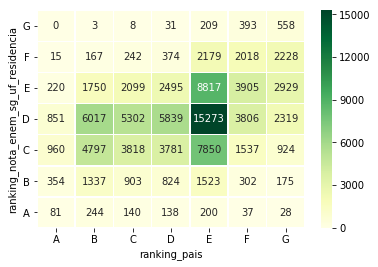

In [15]:
## plot rank - rank
ax = sea.heatmap(pd.crosstab(df_clusters['ranking_nota_enem_sg_uf_residencia'], 
                        df_clusters['ranking_pais']), 
            annot=True, 
            fmt="d", 
            linewidths=.5, 
            cmap="YlGn")
ax.invert_yaxis()

plt.yticks(rotation=0)
plt.show()


[Realizar análise:]

In [16]:

# variáveis utilizadas para regressão
variables = ['sq_ranking_'+str(grade_column) + '_' + group_column, 'sq_ranking_pais']

# define variável dependente
y = 'sq_ranking_'+str(grade_column) + '_' + group_column

# demais serão explicativas
x = [var for var in variables if var not in y ]

# cria dataframe apenas com colunas necessárias
df_ols = df_clusters[variables]

# modelo y = alfa + beta
model = sm.OLS(df_ols[y], add_constant(df_ols[x].astype(float))).fit()
print(model.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.123
Model:                                               OLS   Adj. R-squared:                  0.122
Method:                                    Least Squares   F-statistic:                 1.396e+04
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                                           04:01:12   Log-Likelihood:            -1.4234e+05
No. Observations:                                 100000   AIC:                         2.847e+05
Df Residuals:                                      99998   BIC:                         2.847e+05
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

4. Verifique se existem diferenças estatisticamente significantes entre as estimativas de β e α considerando diferentes sub-amostras:

In [17]:
# filtro escolas privadas / publicas
df_clusters_privada = df_clusters[df_clusters['privada'] == 1]
df_clusters_publica = df_clusters[df_clusters['publico'] == 1]

# filtro mulher / homem
df_clusters_mulheres = df_clusters[df_clusters['feminino'] == 1]
df_clusters_homens = df_clusters[df_clusters['feminino'] != 1]

# filtro pretos / brancos
df_clusters_pretos = df_clusters[df_clusters['preto'] == 1]
df_clusters_brancos = df_clusters[df_clusters['branco'] == 1]

# cria dataframe apenas com colunas necessárias
df_ols_privada = df_clusters_privada[variables]
df_ols_publica = df_clusters_publica[variables]

df_ols_mulheres = df_clusters_mulheres[variables]
df_ols_homens = df_clusters_homens[variables]

df_ols_pretos = df_clusters_pretos[variables]
df_ols_brancos = df_clusters_brancos[variables]

# modelo y = alfa + beta
model_privada = sm.OLS(df_ols_privada[y], add_constant(df_ols_privada[x].astype(float))).fit()
model_publica = sm.OLS(df_ols_publica[y], add_constant(df_ols_publica[x].astype(float))).fit()

model_mulheres = sm.OLS(df_ols_mulheres[y], add_constant(df_ols_mulheres[x].astype(float))).fit()
model_homens = sm.OLS(df_ols_homens[y], add_constant(df_ols_homens[x].astype(float))).fit()

model_pretos = sm.OLS(df_ols_pretos[y], add_constant(df_ols_pretos[x].astype(float))).fit()
model_brancos = sm.OLS(df_ols_brancos[y], add_constant(df_ols_brancos[x].astype(float))).fit()

a. Escolas públicas vs escolas privadas (ensino médio)
[escrever análise]

In [18]:
print(model_privada.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.030
Model:                                               OLS   Adj. R-squared:                  0.029
Method:                                    Least Squares   F-statistic:                     70.67
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):           7.33e-17
Time:                                           04:01:12   Log-Likelihood:                -3028.1
No. Observations:                                   2293   AIC:                             6060.
Df Residuals:                                       2291   BIC:                             6072.
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

In [19]:
print(model_publica.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.107
Model:                                               OLS   Adj. R-squared:                  0.100
Method:                                    Least Squares   F-statistic:                     15.65
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):           0.000124
Time:                                           04:01:12   Log-Likelihood:                -179.05
No. Observations:                                    133   AIC:                             362.1
Df Residuals:                                        131   BIC:                             367.9
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

b. Estudantes homens vs mulheres
[escrever análise]

In [20]:
print(model_mulheres.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.138
Model:                                               OLS   Adj. R-squared:                  0.138
Method:                                    Least Squares   F-statistic:                     9266.
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                                           04:01:12   Log-Likelihood:                -81215.
No. Observations:                                  58100   AIC:                         1.624e+05
Df Residuals:                                      58098   BIC:                         1.625e+05
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

In [21]:
print(model_homens.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.099
Model:                                               OLS   Adj. R-squared:                  0.099
Method:                                    Least Squares   F-statistic:                     4591.
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                                           04:01:12   Log-Likelihood:                -60936.
No. Observations:                                  41900   AIC:                         1.219e+05
Df Residuals:                                      41898   BIC:                         1.219e+05
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

Estudantes pretos vs brancos
[escrever análise]

In [22]:
print(model_pretos.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.072
Model:                                               OLS   Adj. R-squared:                  0.072
Method:                                    Least Squares   F-statistic:                     1002.
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):          8.05e-212
Time:                                           04:01:12   Log-Likelihood:                -17830.
No. Observations:                                  12965   AIC:                         3.566e+04
Df Residuals:                                      12963   BIC:                         3.568e+04
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

In [23]:
print(model_brancos.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.143
Model:                                               OLS   Adj. R-squared:                  0.143
Method:                                    Least Squares   F-statistic:                     5986.
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                                           04:01:12   Log-Likelihood:                -51559.
No. Observations:                                  35957   AIC:                         1.031e+05
Df Residuals:                                      35955   BIC:                         1.031e+05
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
                    

5. Inclua as variáveis de renda familiar dos pais e idade e verifique se os resultados de 3. se modifi- caram. Interpretem os resultados

[escrever análise idade + renda]

In [24]:
# variáveis utilizadas para regressão
variables = ['sq_ranking_'+str(grade_column) + '_' + group_column, 
             'sq_ranking_pais',
             'idade',
             'sq_renda'
            ]

# define variável dependente
y = 'sq_ranking_'+str(grade_column) + '_' + group_column

# demais serão explicativas
x = [var for var in variables if var not in y ]

# cria dataframe apenas com colunas necessárias

df_ols = df_clusters[variables]
df_ols = df_ols.dropna() # removendo linhas NaN

# modelo y = alfa + beta
model_idade_renda = sm.OLS(df_ols[y], add_constant(df_ols[x].astype(float))).fit()

# idade é significante (menos que as demais) e é um fator redutor.
# renda é significante e é um fator com correlação positiva.
print(model_idade_renda.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.216
Model:                                               OLS   Adj. R-squared:                  0.216
Method:                                    Least Squares   F-statistic:                     9207.
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                                           04:01:12   Log-Likelihood:            -1.3667e+05
No. Observations:                                  99998   AIC:                         2.733e+05
Df Residuals:                                      99994   BIC:                         2.734e+05
Df Model:                                              3                                         
Covariance Type:                               nonrobust                                         
                    

[escrever análise apenas renda***]

In [25]:
# variáveis utilizadas para regressão
variables = ['sq_ranking_'+str(grade_column) + '_' + group_column, 
             'sq_ranking_pais',
             'sq_renda'
            ]

# define variável dependente
y = 'sq_ranking_'+str(grade_column) + '_' + group_column

# demais serão explicativas
x = [var for var in variables if var not in y ]

# cria dataframe apenas com colunas necessárias
df_ols = df_clusters[variables]

# modelo y = alfa + beta
model_renda = sm.OLS(df_ols[y], add_constant(df_ols[x].astype(float))).fit()

## como likelihood mudou muito pouco, 
# apesar da idade ser significante não acredito que ela deva entrar na equação 
# TODO: Fazer a conta
print(model_renda.summary())

                                      OLS Regression Results                                     
Dep. Variable:     sq_ranking_nota_enem_sg_uf_residencia   R-squared:                       0.215
Model:                                               OLS   Adj. R-squared:                  0.215
Method:                                    Least Squares   F-statistic:                 1.372e+04
Date:                                   Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                                           04:01:12   Log-Likelihood:            -1.3675e+05
No. Observations:                                 100000   AIC:                         2.735e+05
Df Residuals:                                      99997   BIC:                         2.735e+05
Df Model:                                              2                                         
Covariance Type:                               nonrobust                                         
                    

6. Estimem β e α para cada estado do Brasil2. Existe alguma relação entre a mobilidade intergeracional educacional e informações que vocês conheçam destes estados?

In [26]:
# estimar vetor de betas dos estados
variables = ['sq_ranking_'+str(grade_column) + '_' + group_column, 
             'sq_ranking_pais']

# define variável dependente
y = 'sq_ranking_'+str(grade_column) + '_' + group_column

# demais serão explicativas
x = [var for var in variables if var not in y ]

ufs = df['sg_uf_residencia'].unique()

uf_regressions = []
for uf in ufs:
    # cria dataframe apenas com colunas necessárias
    df_ols_uf = df_clusters[df_clusters['sg_uf_residencia'] == uf][variables]
    # modelo y = alfa + beta
    model_uf = sm.OLS(df_ols_uf[y], add_constant(df_ols_uf[x].astype(float))).fit()   
    #print(model_uf.summary())
    #print(model_uf.params)
    #break
    alfa = None
    beta = None
    if len(model_uf.params) > 0:
        alfa = model_uf.params[0]
    if len(model_uf.params) > 1:
        beta = model_uf.params[1] 
    row = [uf, alfa, beta]
    uf_regressions.append(row)
#uf_regressions










In [27]:
# Prepara os dados

# carrega arquivo de mapas (fonte IBGE)
fp = 'br_unidades_da_federacao//BR_UF_2019.shp'
# transforma dados shpfile para dataframe
map_df = gpd.read_file(fp)
# transforma tabela de alfas / betas em dataframe
df_uf_regressions = pd.DataFrame(uf_regressions, 
                                 columns=['sigla_uf',
                                          'alfa',
                                          'beta'])

# faz o join entre os dois dataframes
merged = map_df.set_index('SIGLA_UF').join(df_uf_regressions.set_index('sigla_uf'))

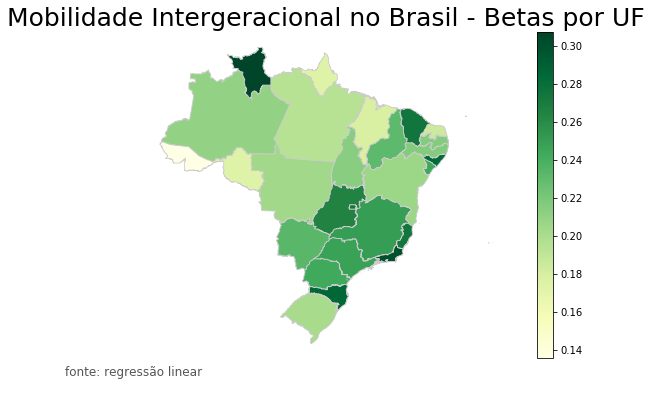

In [28]:
# Gera heat map

# set a variable that will call whatever column we want to visualise on the map
variable = 'beta'
# set the range for the choropleth
vmin, vmax = min(df_uf_regressions.beta), max(df_uf_regressions.beta)
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8')
# remove the axis
ax.axis('off')
# add a title
ax.set_title('Mobilidade Intergeracional no Brasil - Betas por UF', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('fonte: regressão linear',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
#saving our map as .png file.
fig.savefig('map_export.png', dpi=300)